In [ ]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse 

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
from google.colab import drive
drive._mount('/content/drive')

In [ ]:
## Imports
import os
import sys
import random
import numpy as np
from numpy import save
from numpy import load
#
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
#
import cv2
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, 
    BatchNormalization,
    Activation,
    Dense,
    Dropout,
    MaxPooling2D, 
    GlobalMaxPool2D,
    Conv2D,
    Conv2DTranspose,
    UpSampling2D,
    concatenate,
    add,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Seeding
seed=2019
random.seed=seed
np.random.seed=seed
tf.seed=seed

In [ ]:
# Converting the image into the desired form
def load_image(img_path, dsize=(101,101)):
  img = cv2.imread(img_path)
  O_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  O_img = cv2.resize(O_img, dsize)
  
  #Original
  O_img_tensor = img_to_array(O_img)

  #Rotate +90
  #R_img = cv2.rotate(O_img, cv2.ROTATE_90_CLOCKWISE)
  #R_img_tensor = img_to_array(R_img)
  
  #flipud
  Flip_ud = cv2.flip(O_img, 0)
  Flip_ud_tensor = img_to_array(Flip_ud)
  
  #fliplr
  Flip_lr = cv2.flip(O_img, 1)
  Flip_lr_tensor = img_to_array(Flip_lr)

  return O_img_tensor, Flip_lr_tensor, Flip_ud_tensor

In [ ]:
def get_data(filetrains, filevalids):

  path='./drive/My Drive/ImageProcessing/dataset/train'
  
  x_train=[]
  y_train=[]
  
  x_valid=[]
  y_valid=[]


  #print(os.walk(path)
  for files in filetrains:
    img,R_img,N_img = load_image(path+'/images/'+ files + '.png')
    mask,R_mask,N_mask = load_image(path+'/masks/'+ files + '.png')    
    
    img=img/255.0
    mask=mask/255.0
    
    if files not in filevalids:
      R_img=R_img/255.0
      R_mask=R_mask/255.0
      N_img=N_img/255.0
      N_mask=N_mask/255.0

      x_train.append(img)
      y_train.append(mask)

      x_train.append(R_img)
      y_train.append(R_mask)

      x_train.append(N_img)
      y_train.append(N_mask)

    else:
      x_valid.append(img)
      y_valid.append(mask)
  return np.asarray(x_train), np.asarray(y_train), np.asarray(x_valid), np.asarray(y_valid)

In [ ]:
X_test=pd.read_csv('/content/drive/MyDrive/ImageProcessing/test_400.csv') 

In [ ]:
X_test

,id,rle_mask,z
0,b6bbd06618,6490 5 6592 8 6694 11 6795 15 6897 18 6999 21 ...,536
1,b5b767492b,1 9089 9091 96 9192 90 9293 85 9394 79 9495 73...,676
2,3d781526c2,3738 1 3839 2 3940 3 4041 4 4142 6 4243 7 4344...,596
3,6ef46555e2,1568 22 1668 33 1768 43 1869 50 1969 52 2069 5...,385
4,0243477802,NaN,261
...,...,...,...
395,155bcd4b4d,4842 7 4936 14 5031 20 5126 26 5220 33 5314 40...,712
396,340c808130,3839 1 3940 1 4041 2 4142 2 4243 3 4344 4 4445...,660
397,d35af24206,1 70 102 69 203 68 304 66 405 61 506 57 607 52...,782
398,fad11bf2fa,1617 1 1718 2 1819 3 1920 5 2021 6 2122 7 2223...,371


In [ ]:
X_train=pd.read_csv('/content/drive/MyDrive/ImageProcessing/train_3600.csv')

In [ ]:
X_train

,id,rle_mask,z
0,eeecc7ab39,1 5150 5152 98 5253 97 5354 96 5455 95 5556 94...,499
1,868e7a70ae,NaN,286
2,d468d401ab,6388 10 6476 37 6569 57 6668 71 6768 83 6869 9...,408
3,70c8e14243,3229 4 3325 9 3420 15 3516 20 3611 26 3707 31 ...,544
4,25db231ea0,1111 1 1212 1 1312 2 1412 3 1513 3 1613 4 1713...,581
...,...,...,...
3595,638d8572e9,91 11 188 15 285 19 381 24 477 29 573 34 669 3...,336
3596,ac7df612ff,1 34 102 34 203 34 304 34 405 34 506 34 607 33...,614
3597,46386ca4a3,1 18 102 18 203 18 304 18 405 18 506 18 607 18...,695
3598,619edf8941,NaN,625


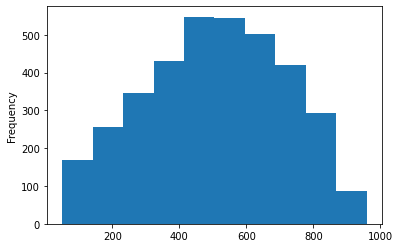

In [ ]:
X_train['z'].plot(kind='hist')

In [ ]:
X=X_train.sort_values('z')

In [ ]:
X=X.drop('z',axis=1)

In [ ]:
X=X.drop('rle_mask', axis=1)

In [ ]:
X['fold'] = (list(range(5)) * X.shape[0])[:X.shape[0]]

In [ ]:
df0 = X.loc[X['fold']==0]
df1 = X.loc[X['fold']==1]
df2 = X.loc[X['fold']==2]
df3 = X.loc[X['fold']==3]
df4 = X.loc[X['fold']==4]

In [ ]:
f0 = pd.merge(X_train,df0,on='id',how='left')
f1 = pd.merge(X_train,df1,on='id',how='left')
f2 = pd.merge(X_train,df2,on='id',how='left')
f3 = pd.merge(X_train,df3,on='id',how='left')
f4 = pd.merge(X_train,df4,on='id',how='left')

In [ ]:
fold=[1,2,3,4,5]
fold[0]=f0.loc[f0['fold']==0]
fold[1]=f1.loc[f1['fold']==1]
fold[2]=f2.loc[f2['fold']==2]
fold[3]=f3.loc[f3['fold']==3]
fold[4]=f4.loc[f4['fold']==4]

In [ ]:
X_train['id'].values

array(['eeecc7ab39', '868e7a70ae', 'd468d401ab', ..., '46386ca4a3',
       '619edf8941', 'd800abe6a4'], dtype=object)

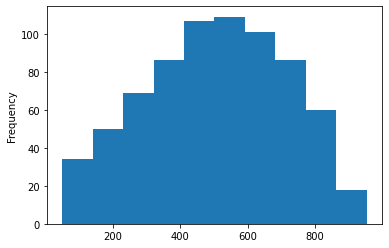

In [ ]:
fold[0]['z'].plot(kind='hist')

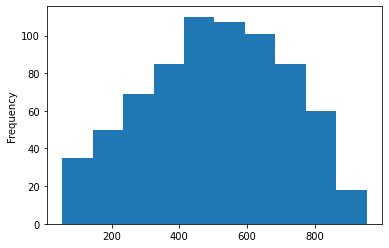

In [ ]:
fold[1]['z'].plot(kind='hist')

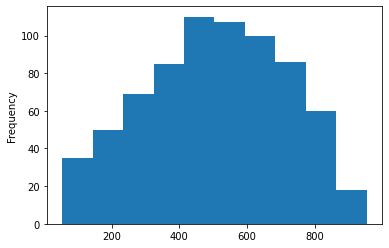

In [ ]:
fold[2]['z'].plot(kind='hist')

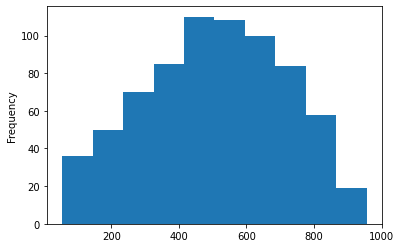

In [ ]:
fold[3]['z'].plot(kind='hist')

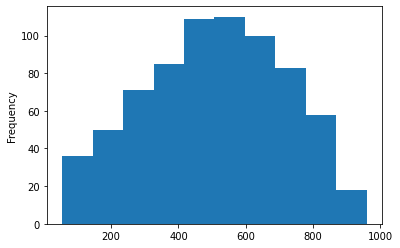

In [ ]:
fold[4]['z'].plot(kind='hist')

In [ ]:
def res_block(x,filter_size,size):
  conv = Conv2D(size,kernel_size=(filter_size,filter_size),padding='same')(x)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)

  conv = Conv2D(size,kernel_size=(filter_size,filter_size),padding='same')(conv)
  conv = BatchNormalization()(conv)
  
  shortcut = Conv2D(size,kernel_size=(1,1),padding='same')(x)
  shortcut = BatchNormalization()(shortcut)

  res = add([shortcut,conv])
  res = Activation('relu')(res)

  return res

In [ ]:
# I tried to make it as simple as possible, I think you can understand the architecture just by looking at the code below
def Res_UNet(input_img):

    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_img)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    
    c1 = res_block(c1,3,16)
    #c1 = BatchNormalization()(c1)
    #c1 = Activation('relu')(c1)
    
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
#-----------------------------------------------------------------------------------------------------------------    
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    c2 = res_block(c2,3,32)
    #c2 = BatchNormalization()(c2)
    #c2 = Activation('relu')(c2)
    
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2) 
#-----------------------------------------------------------------------------------------------------------------    
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    
    c3 = res_block(c3,3,64)
    #c3 = BatchNormalization()(c3)
    #c3 = Activation('relu')(c3)
    
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    c4 = res_block(c4,3,128)
    #c4 = BatchNormalization()(c4)
    #c4 = Activation('relu')(c4)
    
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    c5 = res_block(c5,3,256)
    #c5 = BatchNormalization()(c5)
    #c5 = Activation('relu')(c5)
    
#------UMSAMPLE STARTS---------------------------------------------------------------------------------------------

    u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
    c6 = res_block(c6,3,128)
    #c6 = BatchNormalization()(c6)
    #c6 = Activation('relu')(c6)
    
#---------------------------------------------------------------------------------------------------

    u7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = "valid")(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    c7 = res_block(c7,3,64)
    #c7 = BatchNormalization()(c7)
    #c7 = Activation('relu')(c7)
    
#---------------------------------------------------------------------------------------------------

    u8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    
    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    c8 = res_block(c8,3,32)
    #c8 = BatchNormalization()(c8)
    #c8 = Activation('relu')(c8)
    
#---------------------------------------------------------------------------------------------------

    u9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = "valid")(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    c9 = res_block(c9,3,16)
    #c9 = BatchNormalization()(c9)
    #c9 = Activation('relu')(c9)
    
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

 
    
    model = Model(input_img, outputs)
    return model

In [ ]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0      
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
    return np.mean(metric)

def iou_metric(label, pred):
    return tf.compat.v1.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

In [ ]:
input_img=Input((101, 101, 1), name='img')
model=Res_UNet(input_img)
model.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=[iou_metric])
#model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='2D_5layer_U-Net_Model.png')

In [ ]:
#Using EarlyStopping to stop the training if the algorithm is not converging, 
#ReduceLROnPlateau to change the learning rate in runtime if the algorithm is not converging,
#ModelCheckpoint to save the model time to time whenever there is a imporvement
callbacks = [
    ReduceLROnPlateau(patience=5, verbose=1, monitor='val_iou_metric', min_lr=0.0001, mode ='max', factor=0.5),
    ModelCheckpoint('./drive/My Drive/ImageProcessing/res_unet_input101_GD.h5', mode ='max', monitor='val_iou_metric', verbose=1, save_best_only=True, save_weights_only=True),
    EarlyStopping(monitor='val_iou_metric', mode='max', verbose=1, patience=30)
]

In [ ]:
#model.load_weights('./drive/My Drive/ImageProcessing/res_unet_input128_DG_10ep_3.h5')

In [ ]:
history=[1,2,3,4,5]
ep=100

for i in range(1,2):
  print("###### FOLD", i+1, " ######")

  x_train, y_train, x_valid, y_valid = get_data(X_train['id'].values, fold[i]['id'].values)
  print('len(x_train):',len(x_train),'len(y_train):',len(y_train),'len(x_valid):',len(x_valid), 'len(y_valid):',len(y_valid))
  # train the network
  history[i]=model.fit(x_train, y_train, batch_size=32, epochs=ep, callbacks=callbacks, validation_data=(x_valid,y_valid))
  model.save(r'./drive/My Drive/ImageProcessing/101_GD_final.h5')
  print(K.eval(model.optimizer.lr))

In [ ]:
history[1].history.keys()

dict_keys(['loss', 'iou_metric', 'val_loss', 'val_iou_metric', 'lr'])

**50_normal**

In [ ]:
f, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history[1].epoch

ax2.plot(epoch_list, history[1].history['iou_metric'], label='Train IoU')
ax2.plot(epoch_list, history[1].history['val_iou_metric'], label='Validation IoU')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('IoU Value');ax2.set_xlabel('Epoch');ax2.set_title('IoU')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history[1].history['loss'], label='Train Loss')
ax3.plot(epoch_list, history[1].history['val_loss'], label='Validation Loss')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Loss Value');ax3.set_xlabel('Epoch');ax3.set_title('Loss')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

**50**

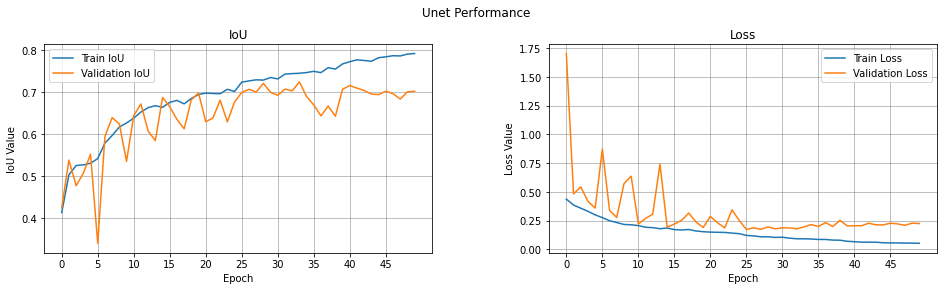

In [ ]:
f, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history[1].epoch

ax2.plot(epoch_list, history[1].history['iou_metric'], label='Train IoU')
ax2.plot(epoch_list, history[1].history['val_iou_metric'], label='Validation IoU')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('IoU Value');ax2.set_xlabel('Epoch');ax2.set_title('IoU')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history[1].history['loss'], label='Train Loss')
ax3.plot(epoch_list, history[1].history['val_loss'], label='Validation Loss')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Loss Value');ax3.set_xlabel('Epoch');ax3.set_title('Loss')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
#model.load_weights('/content/drive/MyDrive/ImageProcessing/New model/res_unet_input128_50ep_final.h5')
score = model.evaluate(x_test, y_test, verbose=1)

13/13 [==============================] - 2s 114ms/step - loss: 0.2104 - iou_metric: 0.6651


**100**

In [ ]:
f, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history[1].epoch

ax2.plot(epoch_list, history[1].history['iou_metric'], label='Train IoU')
ax2.plot(epoch_list, history[1].history['val_iou_metric'], label='Validation IoU')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('IoU Value');ax2.set_xlabel('Epoch');ax2.set_title('IoU')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history[1].history['loss'], label='Train Loss')
ax3.plot(epoch_list, history[1].history['val_loss'], label='Validation Loss')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Loss Value');ax3.set_xlabel('Epoch');ax3.set_title('Loss')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
#model.load_weights('/content/drive/MyDrive/ImageProcessing/New model/res_unet_input128_50ep_final.h5')
score = model.evaluate(x_test, y_test, verbose=1)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history[2].epoch

ax1.plot(epoch_list, history[2].history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history[2].history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history[2].history['iou_metric'], label='Train IoU')
ax2.plot(epoch_list, history[2].history['val_iou_metric'], label='Validation IoU')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('IoU Value');ax2.set_xlabel('Epoch');ax2.set_title('IoU')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history[2].history['loss'], label='Train Loss')
ax3.plot(epoch_list, history[2].history['val_loss'], label='Validation Loss')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Loss Value');ax3.set_xlabel('Epoch');ax3.set_title('Loss')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
def get_data_test(filetest):

  path='./drive/My Drive/ImageProcessing/dataset/train'
  
  
  x_test=[]
  y_test=[]


  #print(os.walk(path)
  for files in filetest:
    img,_,_ = load_image(path+'/images/'+files+'.png')
    mask,_,_ = load_image(path+'/masks/'+files+'.png')
    img=img/255.0
    mask=mask/255.0
    x_test.append(img)
    y_test.append(mask)
  return np.asarray(x_test), np.asarray(y_test)

In [ ]:
X_test=pd.read_csv('./drive/My Drive/ImageProcessing/test_400.csv') 

x_test, y_test = get_data_test(X_test['id'].values)

In [ ]:
model.load_weights('/content/drive/MyDrive/ImageProcessing/model_Kfold_GA_10ep/res_unet_input128_50ep_final.h5')
score = model.evaluate(x_test, y_test, verbose=1)